### wordlabeller.py

### preprocessing.py

In [1]:
import re
import random
import os
import tensorflow as tf
from labeller import WordLabeller


def remove_tag(text):
    # remove <xxx>...</xxx> tags in the given text
    pat = re.compile(r'<[/]?[^>]+>', flags=re.IGNORECASE)
    return pat.sub('', text)

def process_line(text):
    inputs = []
    outputs = []
    
    for word in remove_tag(text).split('|'):
        if word:
            inputs += WordLabeller.get_input_labels(word)
            outputs += WordLabeller.get_output_labels(word)
    return inputs, outputs
        
def _int64_feature(x):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[x]))
    
def list_feature(seq):
    return [_int64_feature(x) for x in seq]

def make_sequence_example(sequence, labels):
    tokens_list_features = list_feature(sequence)
    labels_list_features = list_feature(labels)
    length_feature = _int64_feature(len(sequence))
    
    example = tf.train.SequenceExample(
        context= tf.train.Features(feature={
            'length': length_feature}), 
        feature_lists=tf.train.FeatureLists(feature_list={
            'tokens': tf.train.FeatureList(feature=tokens_list_features),
            'labels': tf.train.FeatureList(feature=labels_list_features)
        }))
    return example

def process_files(input_files, train_outfile, validation_outfile, train_size):
    
    train_writer = tf.python_io.TFRecordWriter(train_outfile)
    val_writer = tf.python_io.TFRecordWriter(validation_outfile)
    
    for i, file in enumerate(input_files, start=1):
        if (i%50==0):
            print("processing file: {}/{}".format(i, len(input_files)))
            
        for line in open(file, 'r').readlines():
            if line:
                inputs, outputs = process_line(line)
                example = make_sequence_example(inputs, outputs)
                if random.random() < train_size:
                    train_writer.write(example.SerializeToString())
                else:
                    val_writer.write(example.SerializeToString())
    print('Finish Processing files: {}/{}'.format(i, len(input_files)))
    train_writer.close()
    val_writer.close()

In [ ]:
list_dirs = [os.path.join('../../BEST_2009/',d) for d in os.listdir('../../BEST_2009/') 
         if os.path.isdir(os.path.join('../../BEST_2009/', d))]

files = [os.path.join(d, file) for d in list_dirs for file in os.listdir(d)]

process_files(files, '/tmp/train.tfrecords', '/tmp/validation.tfrecords', train_size=.9)

In [8]:
#%run preprocessing.py

In [45]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
import os

In [59]:
class WordSegmentation:
    
    # parse each sentence of input and output and length of the sentence from TFRecord file
    @staticmethod
    def _parse_example(example):
        
        context_features = {
            'length': tf.FixedLenFeature(shape=[], dtype=tf.int64)
        }
        sequence_features = {
            'tokens': tf.FixedLenSequenceFeature(shape=[], dtype=tf.int64),
            'labels': tf.FixedLenSequenceFeature(shape=[], dtype=tf.int64)
        }
                                                 
        parsed_context, parsed_sequence = tf.parse_single_sequence_example(serialized=example, 
                                                                           context_features=context_features, 
                                                                           sequence_features=sequence_features)
        return parsed_context['length'], parsed_sequence['tokens'], parsed_sequence['labels']
    
    # read training data from TFRecord file, shuffle, loop over data infinitely and pad to the longest sentence
    @staticmethod
    def _read_training_dataset(data_file, batch_size, buffer_size=10000):
        dataset = tf.data.TFRecordDataset([data_file])
        dataset = dataset.map(WordSegmentation._parse_example)
        dataset = dataset.shuffle(buffer_size)
        dataset = dataset.repeat()
        dataset = dataset.padded_batch(batch_size, padded_shapes=([], [None], [None]))
        return dataset
    
    # read validation data from TFRecord file, and padding
    @staticmethod
    def _read_validation_dataset(data_file, batch_size):
        dataset = tf.data.TFRecordDataset([data_file])
        dataset = dataset.map(WordSegmentation._parse_example)
        dataset = dataset.padded_batch(batch_size, padded_shapes=([], [None], [None]))
        return dataset
    
    # get iterators for training and validation data, a handle variable for alternating
    # between the iterators and a data batch
    @staticmethod
    def _init_iterators(training_dataset, validation_dataset):
        
        # need train_iter, validation_iter, iterator, batch
        handle = tf.placeholder(dtype=tf.string, shape=[])
        iterator = tf.data.Iterator.from_string_handle(handle, 
                                                       output_types=training_dataset.output_types, 
                                                       output_shapes=training_dataset.output_shapes)
        batch = iterator.get_next()
        train_iter = training_dataset.make_one_shot_iterator()
        validation_iter = validation_dataset.make_initializable_iterator()
        
        return train_iter, validation_iter, handle, batch
    
    # build layers for character embeddings and bi-directional RNN with GRU cells
    @staticmethod
    def _build_embedding_rnn(tokens, lengths, char_size, state_size, dropout):
        embedding_weights = tf.Variable(tf.random_uniform(shape=(char_size, state_size), minval=-1., maxval=1.))
        embedding_vectors = tf.nn.embedding_lookup(embedding_weights, tokens)
        
        cell = tf.nn.rnn_cell.GRUCell(num_units=state_size)
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=1.-dropout)
        (output_fw, output_bw), (state_fw, state_bw) = tf.nn.bidirectional_dynamic_rnn(cell_fw=cell, cell_bw=cell, 
                                                                                       inputs=embedding_vectors, 
                                                                                       sequence_length=lengths, 
                                                                                       dtype=tf.float32)
        outputs = tf.concat([output_fw, output_bw], axis=2)
        return embedding_vectors, outputs
    
    @staticmethod
    def _build_fully_connected_layer(inputs, labels, lengths, n_classes):
        logits = tf.layers.dense(inputs=inputs, units=n_classes, activation=None)
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        
        mask = tf.sequence_mask(lengths)
        loss = tf.reduce_mean(tf.boolean_mask(losses, mask))
        masked_prediction = tf.boolean_mask(tf.argmax(logits, axis=2), mask)
        masked_labels = tf.boolean_mask(labels, mask)
        
        return loss, mask, masked_prediction, masked_labels
    
    @staticmethod
    def _build_optimizer(loss):
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.placeholder(tf.float32, shape=[])
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
        return optimizer, global_step, learning_rate
    
    @staticmethod
    def _build_graph(tokens, labels, lengths, char_size, state_size, n_classes, dropout):
        training = tf.placeholder(tf.bool, shape=[])
        
        # embedding & RNN layers
        _, outputs = WordSegmentation._build_embedding_rnn(tokens, lengths, 
                                                           char_size, state_size, dropout)
        
        # fully connected layers
        loss, mask, masked_prediction, masked_labels = WordSegmentation._build_fully_connected_layer(outputs, 
                                                                                                     labels, 
                                                                                                     lengths, n_classes)
        
        # optimizer
        optimizer, global_step, learning_rate = WordSegmentation._build_optimizer(loss)
        
        return loss, masked_prediction, masked_labels, optimizer, global_step, learning_rate, training
    
    
    def __init__(self, training_file, validation_file, buffer_size, batch_size, 
                 char_size, state_size, n_classes, dropout):
        tf.reset_default_graph()
        
        # load training & validation dataset
        training_data = WordSegmentation._read_training_dataset(training_file, batch_size, buffer_size)
        validation_data = WordSegmentation._read_validation_dataset(validation_file, batch_size)
        
        # init training & validation Iterators
        self.tf_train_iter, self.tf_val_iter, self.tf_handle, batch = WordSegmentation._init_iterators(training_data,
                                                                                               validation_data)
        
        # variable batches
        self.tf_batch_lengths, self.tf_batch_tokens, self.tf_batch_labels = batch
        
        # model graph
        self.tf_loss, self.tf_preds, self.tf_labels, self.tf_optimizer, self.tf_global_step,\
        self.tf_learning_rate, self.tf_training = WordSegmentation._build_graph(tokens=self.tf_batch_tokens,
                                                                                labels=self.tf_batch_labels,
                                                                                lengths=self.tf_batch_lengths,
                                                                                char_size=char_size,
                                                                                state_size=state_size,
                                                                                n_classes=n_classes,
                                                                               dropout=dropout)
    
    def _restore_checkpoint(self, session, saver, checkpoint_path):
        saver.restore(session, tf.train.get_checkpoint_state(checkpoint_path).model_checkpoint_path)
        return session.run(self.tf_global_step)
    
    @staticmethod
    def _evaluate(tag, iteration, loss, y_true, y_pred):
        recall = recall_score(y_true, y_pred) * 100
        precision = precision_score(y_true, y_pred) * 100
        f1 = f1_score(y_true, y_pred) * 100
        print("{}: Iteration {}, Loss {:.5f}, Precision {:2.2f}, Recall {:2.2f}, F1 {:2.2f}".format(
        tag, iteration, precision, recall, f1))
        return recall, precision, f1
    
    def train(self, learning_rate, val_period, checkpoint_path, restore_checkpoint=False):
        
        # star session and init variables
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            
            # get handles of train/validation iterators
            train_handle = sess.run(self.tf_train_iter.string_handle())
            val_handle = sess.run(self.tf_val_iter.string_handle())

            last_global_step = 0
            saver = tf.train.Saver()

            # restore checkpoint if requested
            if restore_checkpoint:
                last_global_step = self._restore_checkpoint(sess, saver, checkpoint_path)

            # train forever until satisfied
            iteration = last_global_step
            while True:
                for _ in range(val_period):
                    iteration += 1
                    labels_batch, loss, y_true, y_pred, optimizer = sess.run([self.tf_batch_labels, self.tf_loss, 
                                                                             self.tf_labels, self.tf_preds, 
                                                                             self.tf_optimizer], feed_dict={
                        self.tf_handle: train_handle, self.tf_training: True, self.tf_learning_rate:learning_rate
                    })
                    
                    WordSegmentation._evaluate('Training', iteration, loss, y_true, y_pred)
                
                # validate and save checkpoint during training
                masked_labels_all = np.empty([0], dtype=int)
                masked_preds_all = np.empty([0], dtype=int)
                sess.run(self.tf_val_iter.initializer)
                try:
                    while True:
                        labels_batch, loss, val_trues, val_preds = sess.run([self.tf_batch_labels, self.tf_loss, 
                                                                             self.tf_labels, self.tf_preds],
                                                             feed_dict={
                                                                 self.tf_handle: val_handle,
                                                                 self.tf_training:False
                                                             })
                        np.append(masked_labels_all, val_trues)
                        np.append(masked_preds_all, val_preds)
                except tf.errors.OutOfRangeError:
                    _, _, f1 = WordSegmentation._evaluate('Validation', iteration, 
                                                          loss, masked_labels_all,
                                                          masked_preds_all)
                    saver.save(sess, os.path.join(checkpoint_path, "model_{:2.2f}".format(f1)), 
                               global_step=iteration)
      
    def save_

In [39]:
from labeller import WordLabeller

In [60]:
m = WordSegmentation('train.tfrecords', 'validation.tfrecords', buffer_size=10000, batch_size=8, 
                     char_size=WordLabeller.get_input_vocab_size(), state_size=128, n_classes=2, dropout=.5)

/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [21]:
tf.reset_default_graph()

dataset = tf.data.TFRecordDataset(['train.tfrecords'])
dataset = dataset.map(WordSegmentation._parse_example)
dataset = dataset.shuffle(100)
dataset = dataset.repeat()
dataset = dataset.padded_batch(100, padded_shapes=([], [None], [None]))

data_iter = dataset.make_one_shot_iterator()

handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle, 
                                               output_shapes=dataset.output_shapes, 
                                               output_types=dataset.output_types)

train_iter = dataset.make_initializable_iterator()
opt = tf.train.AdamOptimizer(.01)

opt.minimize()

In [ ]:
tf.train.get_checkpoint_state()

### Tfrecords Guide

In [21]:
%matplotlib inline

import skimage.io as io

In [31]:
# Getting raw data bytes in numpy

cat = io.imread('cat.jpg')
cat.shape

(352, 480, 3)

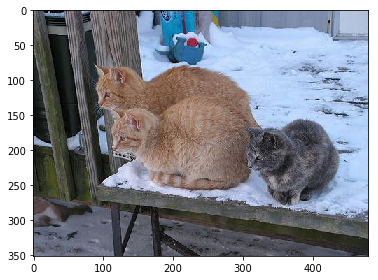

In [26]:
io.imshow(cat)

In [32]:
# convert raw image to string representation
cat_string = cat.tostring()

In [33]:
# convert the string back to image (1d)
restore_cat_1d = np.fromstring(cat_string, dtype=np.uint8)

In [34]:
restore_cat_1d.shape

(506880,)

In [36]:
restore_cat_1d[:10]

array([102, 101, 106, 120, 119, 124, 118, 117, 122,  97], dtype=uint8)

In [37]:
# restore 1d to original shape
restore_cat_img = restore_cat_1d.reshape(cat.shape)

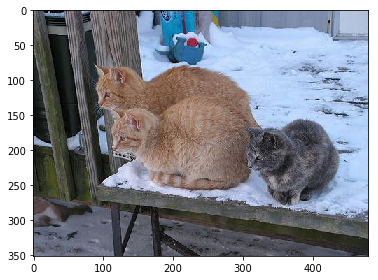

In [38]:
io.imshow(restore_cat_img)

In [39]:
restore_cat_img.shape

(352, 480, 3)

In [40]:
# check if both are the same image
np.allclose(cat, restore_cat_img)

True

### creating a .tfreacord file

In [41]:
import tensorflow as tf
import numpy as np
import skimage.io as io
from PIL import Image

In [52]:
def _byte_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecord_file = 'cat.tfrecords'

In [58]:
writer = tf.python_io.TFRecordWriter(tfrecord_file)

img = np.array(Image.open('cat.jpg'))
annotation = np.array(Image.open('cat_annotation.png'))

height, width = img.shape[:2]

img_raw = img.tostring()
annot_raw = annotation.tostring()

example = tf.train.Example(features=tf.train.Features(feature={
    'height': _int64_feature(height),
    'width': _int64_feature(width),
    'image_raw': _byte_feature(img_raw),
    'mask_raw': _byte_feature(annot_raw)
}))


writer.write(example.SerializeToString())
writer.close()

### reconstruct  image

In [59]:
record_iterator = tf.python_io.tf_record_iterator(tfrecord_file)

record_string = next(record_iterator)

example = tf.train.Example()

example.ParseFromString(record_string)

h = example.features.feature['height'].int64_list.value[0]


w = example.features.feature['width'].int64_list.value[0]


restore_img_string = example.features.feature['image_raw'].bytes_list.value[0]
restore_annot_string = example.features.feature['mask_raw'].bytes_list.value[0]

In [84]:
restore_img = np.fromstring(restore_img_string, dtype=np.uint8).reshape((h, w, -1))
restore_annot = np.fromstring(restore_annot_string, dtype=np.uint8).reshape((h, w, -1))

In [86]:
np.allclose(img, restore_img), np.allclose(annotation, restore_annot)

(True, True)

### Defining the graph to read and batch images from .tfrecords

In [95]:
IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384


def read_and_decode(file_queue):
    reader = tf.TFRecordReader()
    _, examples = reader.read(file_queue)
    
    features = tf.parse_single_example(
        serialized=examples,
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string),
            'mask_raw': tf.FixedLenFeature([], tf.string),
        })
    
    image = tf.decode_raw(features['image_raw'], out_type=tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], out_type=tf.uint8)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image = tf.reshape(image, shape=(height, width, 3))
    annotation = tf.reshape(annotation, shape=(height, width, 1))
    
    image_size = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annot_size = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    resize_image = tf.image.resize_image_with_crop_or_pad(image, 
                                                          target_height=IMAGE_HEIGHT, 
                                                          target_width=IMAGE_WIDTH)
    resize_annotation = tf.image.resize_image_with_crop_or_pad(annotation,
                                                              target_height=IMAGE_HEIGHT,
                                                              target_width=IMAGE_WIDTH)
    
    images, annotations = tf.train.shuffle_batch([resize_image, resize_annotation], batch_size=2)
    
    return images, annotations
    

### How to write into and read from a TFRecords file in TensorFlow

 http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html

In [151]:
import matplotlib.pyplot as plt

In [144]:
import cv2
import sys

In [114]:
# list images and labels
from glob import glob
import random
import os

data_dir = '/home/pongsakorn/Desktop/data/dog_vs_cat/train/'

cat_files = glob(data_dir + 'cats/*.jpg')
dog_files = glob(data_dir + 'dogs/*.jpg')

train_size = .6
val_size = .2
test_size = .2

combine_files = cat_files + dog_files
combine_labels = [0]*len(cat_files) + [1]*len(dog_files)

data = list(zip(combine_files, combine_labels))
random.shuffle(data)
n = len(data)

In [118]:
train_files, train_labels = zip(*data[:int(train_size*n)])
val_files, val_labels = zip(*data[int(train_size*n): int((train_size+val_size)* n)])
test_files, test_labels = zip(*data[int((train_size+val_size)*n):])

In [119]:
len(train_files), len(val_files), len(test_files)

(1279, 427, 427)

In [158]:
def load_image(filename):
    # load image file using cv2  
    # resize to (224*224)
    # comvert from BGR to RGB channels
    img = cv2.imread(filename)
    img = cv2.resize(img, (224, 224), cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

In [159]:
def _byte_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [160]:
# write data to tfrecords file
train_file = 'train.tfrecords'

writer = tf.python_io.TFRecordWriter(train_file)

for i, (x_file, y) in enumerate(zip(train_files, train_labels)):
    
    if (i % 100 == 0):
        print("Train data: {}/{}".format(i+1, len(train_files)))
        sys.stdout.flush()
    
    # load image
    img = load_image(x_file)
    
    # create feature
    feature = {
        'train/image': _byte_feature(tf.compat.as_bytes(img.tostring())),
        'train/label': _int64_feature(y)
    }
    
    # create example
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    writer.write(example.SerializeToString())

print('finish: {}/{}'.format(i+1, len(train_files)))
sys.stdout.flush()
writer.close()

Train data: 1/1279
Train data: 101/1279
Train data: 201/1279
Train data: 301/1279
Train data: 401/1279
Train data: 501/1279
Train data: 601/1279
Train data: 701/1279
Train data: 801/1279
Train data: 901/1279
Train data: 1001/1279


error: /home/travis/miniconda/conda-bld/conda_1486587071158/work/opencv-3.1.0/modules/imgproc/src/imgwarp.cpp:3229: error: (-215) ssize.area() > 0 in function resize


In [ ]:
val_file = 'val.tfrecords'

writer = tf.python_io.TFRecordWriter(val_file)
for i, (x_file, y) in enumerate(zip(val_files, val_labels), start=1):
    
    if (i%20==0):
        print("Validation data: {}/{}".format(i, len(val_files)))
        sys.stdout.flush()
    
    # read image
    img = load_image(x_file)
    
    # create feature
    feature = {
        'val/image': _byte_feature(tf.compat.as_bytes(img.tostring())),
        'val/label': _int64_feature(y)
    }
    
    # create example
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # write to .tfrecord file
    writer.write(example.SerializeToString())
    
print("Finish: {}/{}".format(i, len(val_files)))
writer.close()

In [ ]:
test_file = 'test.tfrecords'

writer = tf.python_io.TFRecordWriter(path=test_file)
for i, (x_file, y) in enumerate(zip(test_files, test_labels), start=1):
    
    if (i%40==0):
        print("Test data: {}/{}".format(i, len(test_files)))
        sys.stdout.flush()
        
    # load image
    img = load_image(x_file)
    
    # create feature
    feature = {
        'test/image': _byte_feature(tf.compat.as_bytes(img.tostring())),
        'test/label': _int64_feature(y)
    }
    # create example
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    writer.write(example.SerializeToString())
    
print("finish: {}/{}".format(i, len(test_files)))
writer.close()

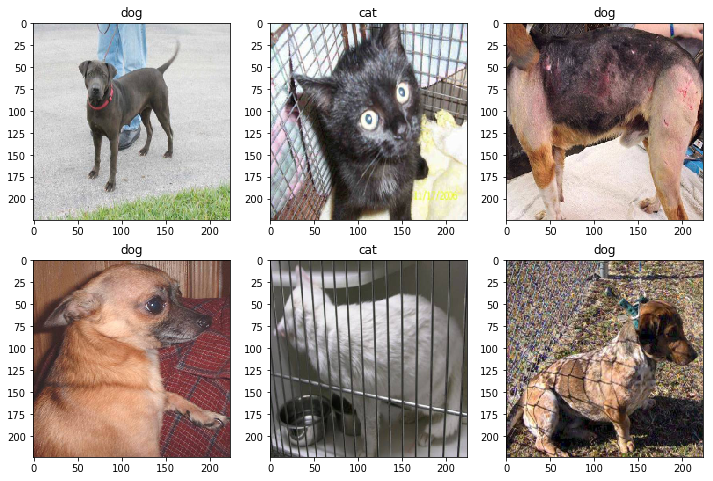

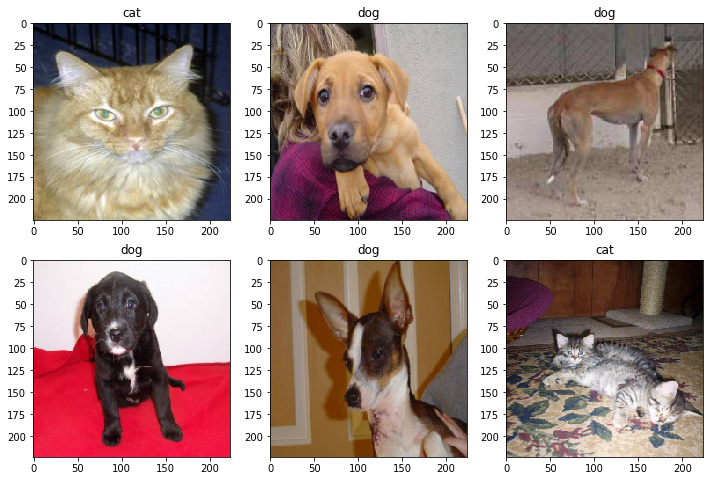

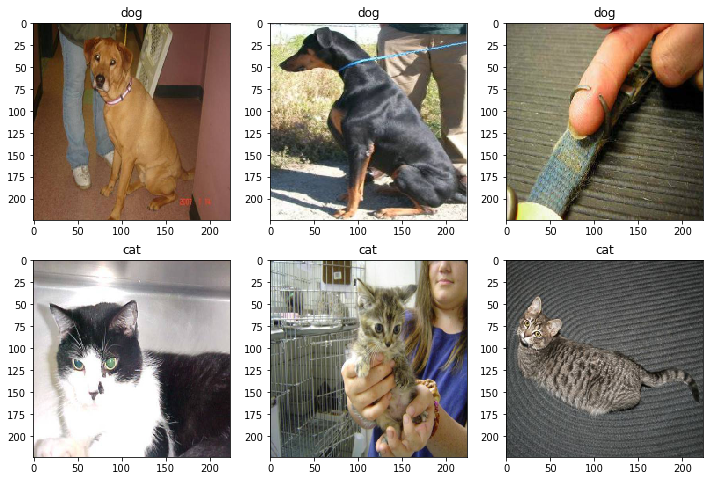

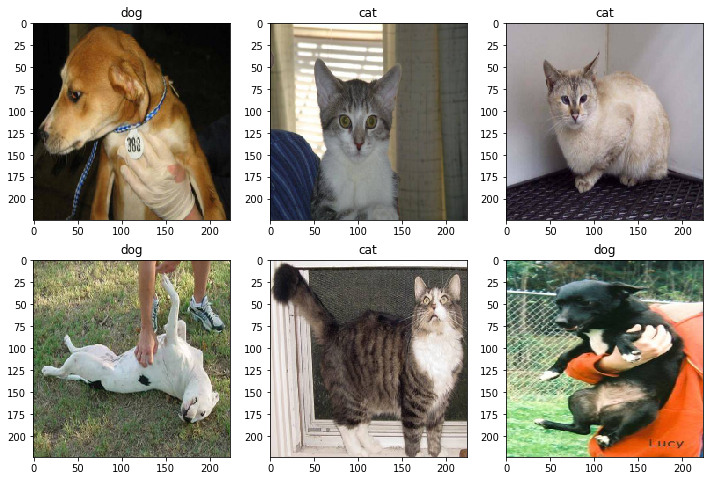

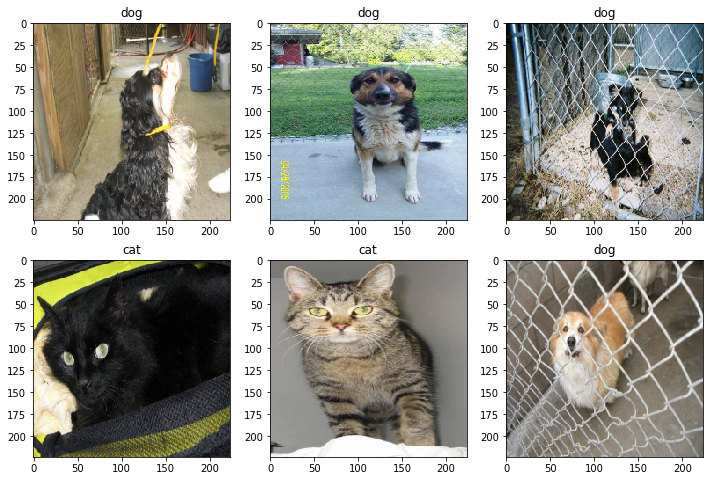

In [161]:
# read tfrecords file

tf.reset_default_graph()
with tf.Session() as sess:
    # create queue
    file_queue = tf.train.string_input_producer([train_file], num_epochs=1)

    # define a reader
    reader = tf.TFRecordReader()
    _, example = reader.read(file_queue)

    # define feature
    feature = {
        'train/image': tf.FixedLenFeature([], tf.string),
        'train/label': tf.FixedLenFeature([], tf.int64),
    }

    # decode the record
    features = tf.parse_single_example(example, features=feature)

    # convert image from string to numbers and reshape
    image = tf.decode_raw(features['train/image'], tf.float32)
    label = tf.cast(features['train/label'], tf.int32)

    image = tf.reshape(image, shape=(224, 224, 3))

    # batching
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, 
                                            num_threads=1, min_after_dequeue=10)

    
    # init variabel
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(5):
        img, lbl = sess.run([images, labels])
        
        img = img.astype(np.uint8)
        
        fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
        for axi, im, l in zip(ax.flat, img, lbl):
            axi.imshow(im)
            axi.set_title('dog' if l else 'cat')
        plt.show()
        
    # stop threads
    coord.request_stop()
    coord.join(threads)
    